**Assignment Description:**
- In this assignment, I plan to use **topic modeling** to help combat hate speech violence on the Twitter platform, now known as 'X'.
- The dataset is sourced from Kaggle: [Hate Speech and Offensive Tweets by Davidson et al](https://www.kaggle.com/datasets/eldrich/hate-speech-offensive-tweets-by-davidson-et-al).
- I have selected two models for comparison based on their performance on the dataset:
  1. Latent Dirichlet Allocation (LDA)
  2. BERTopic
- Please refer to the technical report for detailed interpretations of the model choices, discussions, and comparisons.

**WARNING: The data contains content that is racist, sexist, homophobic, and offensive.**


# **Topic Modelling using BERTopic on conbating Hate-speech on Twitter platform.**

In [ ]:
from google.colab import drive
drive.mount('labeled_data.csv')


Drive already mounted at labeled_data.csv; to attempt to forcibly remount, call drive.mount("labeled_data.csv", force_remount=True).


In [ ]:
import pandas as pd

#Load the CSV file
file_path = '/content/labeled_data.csv/MyDrive/AE2-NLP/Hate speech offensive tweets by Davidson et al/data/labeled_data.csv'
Hate_speech_tweets = pd.read_csv(file_path)

#Keep only target columns (classes information, and the textual information)
review_columns = ['class', 'tweet']
new_HST = Hate_speech_tweets[review_columns]

In [ ]:
#load the dataset
new_HST.head()

,class,tweet
0,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


## Reference Code from Kaggle: Topic Modeling with BERT [1]
### Exploratory Data Analysis:
- Counting the length of tweets.
- Visualizing length distribution.

In [ ]:
#Create a new column containing the length each headline text
new_HST["text_len"] = new_HST["tweet"].apply(lambda x : len(x.split()))

<ipython-input-4-bf02808cde3f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_HST["text_len"] = new_HST["tweet"].apply(lambda x : len(x.split()))


In [ ]:
print("The longest tweets has: {} words".format(new_HST.text_len.max()))


The longest tweets has: 52 words


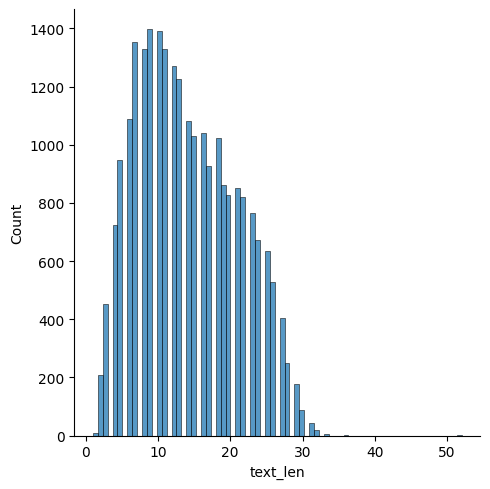

In [ ]:
#Visualize the length distribution
import seaborn as sns
import matplotlib.pyplot as plt
sns.displot(new_HST.text_len, kde=False)

### EDA Continued
- Understanding dataset distribution:
  - 0: Hate speech
  - 1: Offensive language
  - 2: Neither
- Usage of `.value_counts()` [2]

In [ ]:
import pandas as pd

#Calculate the count of each class
class_counts = new_HST['class'].value_counts()

#Print results
print("Distribution of the three classes:")
print(class_counts)


Distribution of the three classes:
class
1    19190
2     4163
0     1430
Name: count, dtype: int64


2. Topic Modeling¶
Training
-  instantiating BERTopic

In [ ]:
!pip install bertopic


## Text Preprocessing
1. Check for missing values.
2. Convert text to lowercase.
3. Remove Twitter handles and URLs.
4. Remove numbers.
5. Tokenization.
6. Remove special characters.

- Did not remove stopwords in comparison with LDA to allow BERT to better understand the contextual relationships, especially given that tweets are relatively short (the longest tweet is 56 characters).

In [ ]:
import string
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import spacy
from nltk.stem import PorterStemmer
import pandas as pd

# Load spaCy
nlp = spacy.load('en_core_web_sm')

# Download NLTK resources
nltk.download("punkt")
nltk.download("wordnet")

def normalised_text(input_text):
    #Check for missing value
    if pd.isna(input_text):
        return []

    #Lowercase
    lower_string = input_text.lower()

    #Remove Twitter handles and URLs
    lower_string = re.sub(r'@\w+:', '', lower_string)  # Removes Twitter handles like @mayasolovely:
    lower_string = re.sub(r'http[s]?://\S+', '', lower_string)  # Removes URLs

    #Remove numbers
    no_numbers_string = re.sub(r'[0-9]', '', lower_string)

    # Tokenization
    tokens = word_tokenize(no_numbers_string)

    # Remove special characters and punctuation from tokens
    tokens = [token for token in tokens if token.isalnum()]


    return tokens


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Apply Preprocess Function `normalised_text`

In [ ]:
import pandas as pd
from bertopic import BERTopic

#Create a copy incase mistakes
cleaned_HST = new_HST.copy()

#Apply the normalised_text function to the 'tweet' column
cleaned_HST['cleaned_tweet'] = cleaned_HST['tweet'].apply(normalised_text)  # Column name fixed here

#display and check my df
print(cleaned_HST.head())


   class                                              tweet  text_len  \
0      2  !!! RT @mayasolovely: As a woman you shouldn't...        25   
1      1  !!!!! RT @mleew17: boy dats cold...tyga dwn ba...        16   
2      1  !!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...        21   
3      1  !!!!!!!!! RT @C_G_Anderson: @viva_based she lo...         9   
4      1  !!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...        26   

                                       cleaned_tweet  
0  [rt, as, a, woman, you, should, complain, abou...  
1  [rt, boy, dats, cold, tyga, dwn, bad, for, cuf...  
2  [rt, urkindofbrand, dawg, rt, you, ever, fuck,...  
3                   [rt, she, look, like, a, tranny]  
4  [rt, the, shit, you, hear, about, me, might, b...  


**Debugging**
- After applying the function, I received the error: `TypeError: Make sure that the iterable only contains strings.`
- Therefore, I applied `.astype(str)` to ensure all entries are strings. [3]

In [ ]:
#ensure all entries are strings
cleaned_HST['cleaned_tweet'] = cleaned_HST['tweet'].apply(normalised_text).astype(str)


## Reference [1]
- Initialize BERTopic model:
  1. `verbose = true`: Allows detailed console outputs to help identify issues during execution.
  2. Model from the reference: 'paraphrase-MiniLM-L3-v2' — This is a sentence-transformers model that maps sentences and paragraphs to a 384-dimensional dense vector space, which can be used for tasks like clustering or semantic search. [4]
  3. `min_topic_size`: Topics containing fewer than 7 documents will be filtered out to reduce meaningless noise.

- In this dataset, based on the characteristics of tweets, we consider:
  1. The direct and concise nature of tweets suggests that a smaller `min_topic_size` may capture more nuanced meanings.
  2. Data balance: Since class 0 (hate speech) is significantly larger than other classes, a smaller `min_topic_size` can increase the likelihood of identifying less represented topics.
  
  Therefore, we choose 7, a relatively small number for `min_topic_size`.

In [ ]:
#Initialise BERTopic
model = BERTopic(verbose=True, embedding_model='paraphrase-MiniLM-L3-v2', min_topic_size=7)

#Fit the model and transform the data
#Ensure to pass only the column with cleaned texts
topics, _ = model.fit_transform(cleaned_HST['cleaned_tweet'].tolist()) #convert to list
print("Topic modeling completed successfully.")


2024-04-12 21:22:06,682 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/775 [00:00<?, ?it/s]

2024-04-12 21:28:16,496 - BERTopic - Embedding - Completed ✓
2024-04-12 21:28:16,500 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2024-04-12 21:29:10,147 - BERTopic - Dimensionality - Completed ✓
2024-04-12 21:29:10,149 - BERTopic - Cluster - Start clustering the reduced embeddings
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
2024-04-12 21:29:15,347 - BERTopic - Cluster - Completed ✓
2024-04-12 21:29:15,360 - BERTopic - Representation - Extracting topics from clusters using representation models.
2024-04-12 21:29:16,395 - BERTopic - Representation - Completed ✓


Topic modeling completed successfully.


## Topic Extraction and Representation
- `model.get_topic_info`: Retrieves information about the topics, which includes:
  1. **Topic**: A unique identifier for each topic, represented as an integer. `-1` indicates an outlier that does not fit well in any topic.
  2. **Count**: The number of documents associated with that topic.
  3. **Name**: A generated name for each topic, typically comprising the most representative words from that topic.

In [ ]:
freq = model.get_topic_info()
print("Number of topics: {}".format( len(freq)))
freq.head()

Number of topics: 312


,Topic,Count,Name,Representation,Representative_Docs
0,-1,14691,-1_you_bitch_to_my,"[you, bitch, to, my, bitches, that, me, the, a...","[['what', 'that', 'hoe', 'was', 'like'], ['me'..."
1,0,444,0_she_her_girl_bad,"[she, her, girl, bad, bitch, shes, this, pussy...","[['fuck', 'her', 'pussy', 'fuck', 'her', 'mout..."
2,1,355,1_white_whitey_black_trash,"[white, whitey, black, trash, people, racist, ...","[['i', 'hate', 'when', 'those', 'little', 'whi..."
3,2,348,2_she_her_girl_rt,"[she, her, girl, rt, if, girlfriend, does, hoe...","[['rt', 'i', 'feel', 'like', 'no', 'matter', '..."
4,3,336,3_yankees_yankee_jeter_derek,"[yankees, yankee, jeter, derek, mlb, stadium, ...","[['done', 'for', 'the', 'yankees'], ['rt', 'le..."


### The Words c-TF-IDF Score:
  - The higher the score, the more relevant the word is in representing the topic.
  - From this topic [1], we can see:

In [ ]:
each_topic = freq.iloc[2]["Topic"] # Select the 1st topic
model.get_topic(each_topic) # Show the words and their c-TF-IDF scores

[('white', 0.08098387906984113),
 ('whitey', 0.016838638394043766),
 ('black', 0.01334036799933145),
 ('trash', 0.012514308058452897),
 ('people', 0.008279996724963547),
 ('racist', 0.007332367955077791),
 ('colored', 0.005517705251782793),
 ('full', 0.005069708610815048),
 ('whitecholo', 0.004887662357743443),
 ('man', 0.0047615810109404855)]

##Topics Visualisation

In [ ]:
model.visualize_barchart(top_n_topics=10)


## Bibliography

[1] "Topic Modeling With BERT," Kaggle. Available: https://www.kaggle.com/code/bansodesandeep/topic-modeling-with-bert. [Accessed Apr. 13, 2024].

[2] "pandas.DataFrame.value_counts — pandas 1.4.1 documentation," Pandas. Available: https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.value_counts.html.

[3] "Python | Pandas Series.astype() to convert Data type of series," GeeksforGeeks, Oct. 01, 2018. Available: https://www.geeksforgeeks.org/python-pandas-series-astype-to-convert-data-type-of-series/. [Accessed Apr. 13, 2024].

[4] "sentence-transformers/paraphrase-MiniLM-L3-v2," Hugging Face. Available: https://huggingface.co/sentence-transformers/paraphrase-MiniLM-L3-v2.

[5] P. Pai, "Hierarchical clustering explained," Medium, May 10, 2021. Available: https://towardsdatascience.com/hierarchical-clustering-explained-e59b13846da8.